In [5]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
from __future__ import print_function
import sys
import tarfile
import numpy
import itertools
from sklearn import *
import scipy
from collections import OrderedDict
import matplotlib.cm as cm

#nprocs = [16, 32, 64, 128, 256, 512, 1024, 2048]
#nprocs = [16, 32,64,128,256,2048]
nprocs = [32,64]

#totalTime = [4.2649,2.6026,2.3072,2.1346,4.2532,2.69,2.9182,3.375] #TEST_ft_7
#totalTime = [60.4537,106.6427,19.4273,12.7305,9.2087] #TEST_ft_D
#totalTime = [53.7934,118.1596,18.0512,12.7136,9.9611] #TEST_ft_D_2
#totalTime = [715.0507,441.539,186.9814,94.1689,51.7973]# ft
#totalTime = [472.647,263.4467,150.0709,93.653,54.5149,16.8697] #sweep3d
totalTime = [123, 607.3646]
#totalTime = [70.58,35.5263,12.9775,8.6173] #incert4
#totalTime = [39.4902,22.5346,7.8422,6.7449] #no incert
colors = cm.rainbow(numpy.linspace(0, 1, 150))

(COMPUTING, COMBINE, CALL_INDIRECT, CALL_REC, CALL, FUNCTION, COMPOUND, BRANCH, LOOP) = (i for i in range(-9, 0, 1))

topk = OrderedDict()

rootResult = list()
uniqId = 0

class Node(object):
    def __init__(self,
                 i,
                 id,
                 type,
                 #firstType,
                 #lastType,
                 numChildren,
                 dirID,
                 fileID,
                 lineNum,
                 exitLineNum,
                 sampleCount,
                 sumTime):
        self.uniqueId = i
        self.id = id
        self.type = type
        #self.firstType = firstType
        #self.lastType = lastType
        self.children = [None] * numChildren
        self.dirID = dirID
        self.fileID = fileID
        self.lineNum = lineNum
        self.exitLineNum = exitLineNum
        self.sumTime = sumTime
        self.sampleCount = sampleCount
        if numChildren == 0 :
            self.flagNode =  1 # init flagNode =1 to all leaves
        else :
            self.flagNode =  0
        # sumTime only
        self.sumTimeList = [sumTime]
        self.sumTimeSecList = []
        self.hasMulTotalTime = 0
        self.pred = 0
        self.crossPreds = []
        
        #print (  i,id,type,numChildren,dirID,fileID,lineNum,sumTime)

    def gatherOne(self, node):
        self.sumTimeSecList.append(node.sumTimeList)
        for i in range(len(self.children)):
            self.children[i].gatherOne(node.children[i])
    
    def gatherStat(self, node):
        self.sumTimeList += node.sumTimeList
        for i in range(len(self.children)):
            self.children[i].gatherStat(node.children[i])

    def getNodeNum(self):
        num = 1
        if self.type < 0 and self.type not in (FUNCTION, COMPOUND, BRANCH, LOOP):
            num = 0
        if len(self.children) == 0:
            return num
        for child in self.children:
            num += child.getNodeNum()
        return num

    

    

def readTree(f):
    global uniqId
    types = [int, int, int, int, int, int, int, int, float]
    args = list(map(lambda x: x[0](x[1]), zip(types, f.readline().decode('utf-8').strip().split(' '))))
    args.insert(0, uniqId)
    uniqId += 1
    node = Node(*args)
    for i in range(len(node.children)):
        node.children[i] = readTree(f)
    return node

def trimTree(node):
    for child in node.children:
        trimTree(child)

    remove = [False] * len(node.children)
    for i in range(len(node.children)):
        child = node.children[i]
        if child.type in (CALL_REC, CALL_INDIRECT):
            assert len(child.children) == 0
            remove[i] = True
        elif child.type == CALL:
            assert len(child.children) == 1 and child.children[0].type == FUNCTION
            node.children[i] = child.children[0]
        elif child.type == BRANCH:
            assert child.sumTime == 0
            sumTime = 0
            for cc in child.children:
                sumTime += cc.sumTime
            child.sumTime = sumTime
            child.sumTimeList = [sumTime]
    newChildren = []
    for i in range(len(node.children)):
        if not remove[i]:
            newChildren.append(node.children[i])
    node.children = newChildren

def printTime(node, depth):
    print(' ' * depth, end='')
    print([node.type, node.sumTime, node.numEntries])
    for child in node.children:
        printTime(child, depth + 1)


def gatherTime(node):
    def gatherTimeRec(node, out):
        out.append((node.type, node.sumTime))
        for child in node.children:
            gatherTimeRec(child, out)
    ret = []
    gatherTimeRec(node, ret)
    return ret


def sumLeaves(node):
    if len(node.children) == 0:
        return node.sumTime
    sumTime = 0
    for child in node.children:
        sumTime += sumLeaves(child)
    return sumTime


def gatherLeafTimeRec(node, out):
    if len(node.children) == 0:
        out.append(node.sumTime)
        return
    for child in node.children:
        gatherLeafTimeRec(child, out)

def predictWithLeaves(train_nps, train_trees, pred_np, pred_func):
    trainLeafTime = []
    for tree in train_trees:
        leafTime = []
        gatherLeafTimeRec(tree, leafTime)
        trainLeafTime.append(leafTime)
    trainLeafTime = list(map(list, zip(*trainLeafTime)))
    preds = []
    for nt in trainLeafTime:
        pt = pred_func(train_nps, nt, pred_np)
        preds.append(pt)
    #b = numpy.array(preds)
    print (preds)
    # print(','.join(list(map(str, preds))))
    return numpy.sum(preds)

def mulTotalTime(node):
    if node.hasMulTotalTime == 0:
        for i in range(len(node.sumTimeSecList)):
            for j in range(len(node.sumTimeSecList[i])):
                node.sumTimeSecList[i][j] = node.sumTimeSecList[i][j] * totalTime[i]
        node.hasMulTotalTime = 1
    for i in range(len(node.children)):
        mulTotalTime( node.children[i])

if __name__ == '__main__':
    # overhead()
    # exit(0)
    # bms = ['bt', 'cg', 'ep', 'ft', 'mg', 'sp', 'lu', 'is']
    #bms = ['bt', 'cg', 'ft', 'lu', 'is']

    #bms = ['ft']
    bms = ['cg']
    np1 = nprocs

    #tf = tarfile.open('./ft_D_64_4_barrier.tar.gz', 'r')
    tf = tarfile.open('./cg-insert-test.tar.gz', 'r')
    #tf = tarfile.open('./SWEEP3D.tar.gz','r')
    for bm in bms:
        nps = np1
        # print(bm)

        mergedTrees = []
        print ("**********")
        for np in nps: 
            # Read trees
            uniqId = 0
            trees = []
            for rank in range(np):
            #for rank in range(1):  # read only process 1 : stat0.txt
                path = 'run-with-all-leafnode/C/%s/%d/stat%d.txt' % (bm, np, rank)
                #path = './%s/%d/stat%d.txt' % (bm, np, rank)
                f = tf.extractfile(tf.getmember(path))
                root = readTree(f)
                # print(root.getNodeNum())
                #trimTree(root)
                trees.append(root)
                
            for i in range(1, np):
                trees[0].gatherStat(trees[i])
            
            
            #mergeTrees(trees)
            mergedTrees.append(trees[0]) # contains all stat.txt of all nps

        for i in range(len(mergedTrees)):
            mergedTrees[0].gatherOne(mergedTrees[i])

        print ("..........")
        gatheredTree = mergedTrees[0]  # merge[i] is merged to merge[0] 

       # mulTotalTime(gatheredTree)
        
        
        


**********


ValueError: invalid literal for int() with base 10: '12.0077'

In [4]:
totalTime = [31.98,13.43,9.19,4.42,3.64,1.71]
def devideTotalTime(node):
    if node.hasMulTotalTime == 1:
        for i in range(len(node.sumTimeSecList)):
            for j in range(len(node.sumTimeSecList[i])):
                node.sumTimeSecList[i][j] = node.sumTimeSecList[i][j] / totalTime[i]
        node.hasMulTotalTime = 0
    for i in range(len(node.children)):
        devideTotalTime( node.children[i])

#mulTotalTime(gatheredTree)
devideTotalTime(gatheredTree)

[0.229349, 0.203345, 0.0, 0.217434, 0.212082, 0.219441, 0.0, 0.215724, 0.00118624, 0.00098264, 0.00455581, 0.000657246, 0.224042, 0.220138, 0.000664231, 0.273298]
[0.0174927, 0.0347655, 0.0313015, 0.0136099, 0.0383241, 0.0256827, 0.0338593, 0.0272904, 0.007414, 0.24828, 0.242434, 0.280973, 0.0153947, 0.0111879, 0.0225839, 0.00693985]
[0.63978, 0.638898, 0.643822, 0.652301, 0.626827, 0.642718, 0.639382, 0.633853, 0.531139, 0.638061, 0.640742, 0.597437, 0.604324, 0.603159, 0.599136, 0.612029]
[0.00259151, 0.0167268, 0.217463, 0.00680493, 0.0116921, 0.00195059, 0.215648, 0.00649773, 0.00355872, 0.00655093, 0.00065083, 0.00657246, 0.0507697, 0.0562685, 0.27466, 0.00198282]


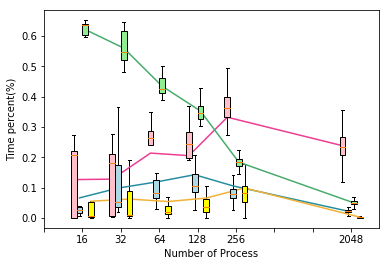

In [7]:
#sweep3d
from matplotlib.ticker import FuncFormatter
def findNodeWithUniqueId(node, uid):
    if node.uniqueId == uid: 
        return node, True;
    for child in node.children:
        #Node* findNode = nullptr
        findNode, findFlag = findNodeWithUniqueId(child, uid);
        if findFlag == True:
            return findNode, True;
    return node, False

def copyNodeData(node, data):
    for i in range(len(nprocs)):
        data[i] = node.sumTimeSecList[i]
    
def calculateMean(a):
    result = []
    for i in range(len(a)):
        mean = 0;
        for j in range(len(a[i])):
            mean += a[i][j]
        mean =  mean / len(a[i])
        result.append(mean);
    return result    

findNode, findFlag = findNodeWithUniqueId(gatheredTree,196)
#print(findNode.uniqueId)
data1 = [None] * len(nprocs)
#print(findNode.sumTimeSecList[5])
#print(nprocs)
copyNodeData(findNode, data1)
print(data1[0])

findNode, findFlag = findNodeWithUniqueId(gatheredTree,179)
#print(findNode.uniqueId)
data2 = [None] * len(nprocs)
copyNodeData(findNode, data2)
print(data2[0])


findNode, findFlag = findNodeWithUniqueId(gatheredTree,174)
#print(findNode.uniqueId)
data3 = [None] * len(nprocs)
copyNodeData(findNode, data3)
print(data3[0])


findNode, findFlag = findNodeWithUniqueId(gatheredTree,163)
#print(findNode.uniqueId)
data4 = [None] * len(nprocs)
copyNodeData(findNode, data4)
print(data4[0])


all_data = [data1[0],data2[0],data3[0],data4[0],
            data1[1],data2[1],data3[1],data4[1],
            data1[2],data2[2],data3[2],data4[2],
            data1[3],data2[3],data3[3],data4[3],
            data1[4],data2[4],data3[4],data4[4],
            data1[5],data2[5],data3[5],data4[5]]

labels = [
            '  ',' 16',' ',' ',
          '  ', ' 32',' ',' ',
          '  ', ' 64',' ',' ',
          '  ' , ' 128',' ',' ',
          '  ' ,' 256',' ',' ',
          '  ',' 2048',' ',' ']
position = [0.775,0.925,1.075,1.225,
            1.775,1.925,2.075,2.225,
            2.775,2.925,3.075,3.225,
            3.775,3.925,4.075,4.225,
            4.775,4.925,5.075,5.225,
            7.775,7.925,8.075,8.225]

bplot = plt.boxplot(all_data, patch_artist=True, widths=0.15, labels=labels,positions=position, showfliers=False,showmeans=False)  # 设置箱型图可填充
#plt.title('Bo')
#bplot = plt.boxplot(all_data, patch_artist=True, widths=0.15, labels=labels,positions=position)#, showfliers=False,showmeans=False)  # 设置箱型图可填充
#plt.title('Bo')

colors = ['pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)  # 为不同的箱型图填充不同的颜色
    
mean1 = calculateMean(data1)
mean2 = calculateMean(data2)
mean3 = calculateMean(data3)
mean4 = calculateMean(data4) 
    
meanposit1 = [0.775,1.775,2.775,3.775,4.775,7.775]
meanposit2 = [0.925,1.925,2.925,3.925,4.925,7.925]
meanposit3 = [1.075,2.075,3.075,4.075,5.075,8.075]
meanposit4 = [1.225,2.225,3.225,4.225,5.225,8.225]

plt.plot(meanposit1,mean1,color = '#ED3C92')
plt.plot(meanposit2,mean2,color = '#258DA1')
plt.plot(meanposit3,mean3,color = '#47AB6C')
plt.plot(meanposit4,mean4,color = '#F2B134')

#plt.yaxis.grid(True)
#plt.yscale('log', basey=10)

#fmt = '%1.0f%%' # Format you want the ticks, e.g. '40%'
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'

#yticks = mtick.FormatStrFormatter(fmt)
#plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.ylabel('Time percent(%)')
plt.xticks(numpy.arange(9),[' ','16','32','64','128','256',' ',' ','2048'])
plt.xlabel('Number of Process')
plt.savefig('cg.pdf',bbox_inches='tight')
plt.show()



In [3]:
def swapNode(x, y):
    uniqueId = x.uniqueId
    iid = x.id
    ttype = x.type
    children = x.children
    dirID = x.dirID
    fileID = x.fileID
    lineNum = x.lineNum
    exitLineNum = x.exitLineNum
    sumTime = x.sumTime
    sampleCount = x.sampleCount
    flagNode =  x.flagNode
    sumTimeList = x.sumTimeList
    sumTimeSecList = x.sumTimeSecList
    
    x.uniqueId = y.uniqueId
    x.id = y.id
    x.type = y.type
    x.children = y.children
    x.dirID = y.dirID
    x.fileID = y.fileID
    x.lineNum = y.lineNum
    x.exitLineNum = y.exitLineNum
    x.sumTime = y.sumTime
    x.sampleCount = y.sampleCount
    x.flagNode =  y.flagNode
    x.sumTimeList = y.sumTimeList
    x.sumTimeSecList = y.sumTimeSecList
    
    y.uniqueId = uniqueId
    y.id = iid
    y.type = ttype
    y.children = children
    y.dirID = dirID
    y.fileID = fileID
    y.lineNum = lineNum
    y.exitLineNum = exitLineNum
    y.sumTime = sumTime
    y.sampleCount = sampleCount
    y.flagNode =  flagNode
    y.sumTimeList = sumTimeList
    y.sumTimeSecList = sumTimeSecList
    


def sortByLineNum(node):
    if len(node.children) > 1:
        
        for i in range(len(node.children)) :
            k = i
            for j in range(i,len(node.children)) :
                if node.children[j].lineNum < node.children[k].lineNum :
                    k = j 
            swapNode(node.children[k],node.children[i])
            #node->children[i]->childID = i;
    
    #else:
    #    if len(node.children) == 1:
    #    node->children[0]->parent = node;
    #    node->children[0]->childID = 0;
    
    for child in node.children :
        sortByLineNum(child)
    


def printTime(node, depth):
    print('   ' * depth, end='')
    print([node.uniqueId,node.type, node.sumTime,node.lineNum])
    for child in node.children:
        printTime(child, depth + 1)



#printTime(gatheredTree,0)

sortByLineNum(gatheredTree)        
print('  ')
#printTime(gatheredTree,0)

In [25]:
dictForComm = dict()

tmpListForSubset = []
tmpListForFirstCommOfLoop  = []

i= 3


def splitGraph(node,loopFlag): # second parameter is loop depth
    global tmpListForSubset,tmpListForFirstCommOfLoop,dictForComm
    if len(node.children) == 0:
        if node.type < 0:
            zeroflag = True
            for j in range(len(node.sumTimeSecList[i])):
                if node.sumTimeSecList[i][j] > 0.0:
                    zeroflag = False
                    #notZeroCount+=1
                    break
            if zeroflag == False:
                tmpListForSubset.append(node)
        if node.type >=0:
            if loopFlag > 0 and len(tmpListForFirstCommOfLoop) < loopFlag:
                tmpListForFirstCommOfLoop.append(node)
            dictForComm[node] = tmpListForSubset
            tmpListForSubset = []
    
    if node.type == LOOP:
        loopFlag = loopFlag + 1
    
    for child in node.children:
        splitGraph(child,loopFlag)
    
    if node.type == LOOP:
        if len(tmpListForFirstCommOfLoop) == loopFlag:
            addToNode = tmpListForFirstCommOfLoop.pop(-1)
            tmpListForSubset += dictForComm[addToNode]
            dictForComm[addToNode] =  tmpListForSubset
            tmpListForSubset = []
            loopFlag = loopFlag - 1


splitGraph(gatheredTree,0)
       
    
#print('**')
#for k,v in dictForComm.items():
#    print(k.uniqueId,k.type,sep='   ')
#    for node in v:
#        print('        ',node.uniqueId,node.type)

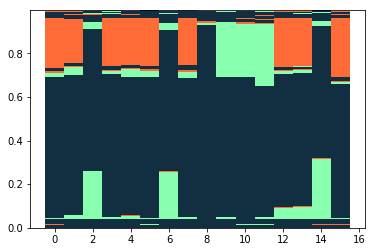

In [22]:
#DFS

import numpy
commcolors = cm.rainbow(numpy.linspace(0, 1, 30))
i = 0
bottom=numpy.zeros(nprocs[i])

def criticalPath(node,i):
    global bottom
    if len(node.children) == 0:
        zeroflag = True
        for j in range(len(node.sumTimeSecList[i])):
            if node.sumTimeSecList[i][j] > 0.0:
                zeroflag = False
                break
        if zeroflag == False:
            index = range(len(node.sumTimeSecList[i]))
            bar_width = 1
            data = node.sumTimeSecList[i]
            if node.type >= 0:
                plt.bar(index, data,bar_width,color=commcolors[node.type%30],bottom = bottom)
            else: 
                plt.bar(index, data,bar_width,color='#112F41',bottom = bottom)
            bottom = [a+b for a,b in zip(bottom,data)]
            
    for child in node.children:
         criticalPath(child,i)


    


criticalPath(gatheredTree,i)
plt.show()




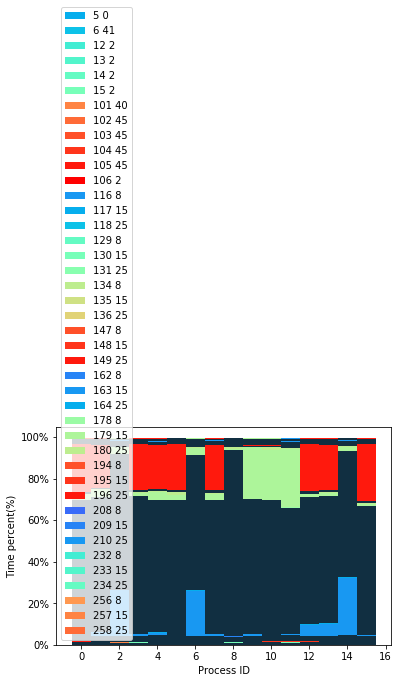

In [26]:
#dependency

commcolors = cm.rainbow(numpy.linspace(0, 1, 30))
for i in range(1):
    bottom=numpy.zeros(nprocs[i])
    commlist = []
    notZeroCount = 0

    for k,v in dictForComm.items():
        for node in v:
            zeroflag = True
            #print(node.uniqueId)
            index = range(len(node.sumTimeSecList[i]))
            bar_width = 1
            data = node.sumTimeSecList[i]
            plt.bar(index, data,bar_width,color='#112F41',bottom = bottom)
            bottom = [a+b for a,b in zip(bottom,data)]
    
        node = k
        index = range(len(node.sumTimeSecList[i]))
        bar_width = 1
        data = node.sumTimeSecList[i]
        if node.id not in commlist:
            commlist.append(node.id)
            plt.bar(index, data,bar_width,color=commcolors[(node.id)%30],bottom = bottom,label = str(node.uniqueId)+" "+str(node.type))
        else:
            plt.bar(index, data,bar_width,color=commcolors[(node.id)%30],bottom = bottom)
        bottom = [a+b for a,b in zip(bottom,data)]

#print(notZeroCount)
    plt.legend()
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.ylabel('Time percent(%)')
    #plt.ylabel('Time (s)')
    plt.xlabel('Process ID')
    plt.show()

196 1294
[0.229349, 0.203345, 0.0, 0.217434, 0.212082, 0.219441, 0.0, 0.215724, 0.00118624, 0.00098264, 0.00455581, 0.000657246, 0.224042, 0.220138, 0.000664231, 0.273298]
179 1218
[0.0174927, 0.0347655, 0.0313015, 0.0136099, 0.0383241, 0.0256827, 0.0338593, 0.0272904, 0.007414, 0.24828, 0.242434, 0.280973, 0.0153947, 0.0111879, 0.0225839, 0.00693985]
169 1182
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.348161, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
163 1247
[0.00259151, 0.0167268, 0.217463, 0.00680493, 0.0116921, 0.00195059, 0.215648, 0.00649773, 0.00355872, 0.00655093, 0.00065083, 0.00657246, 0.0507697, 0.0562685, 0.27466, 0.00198282]


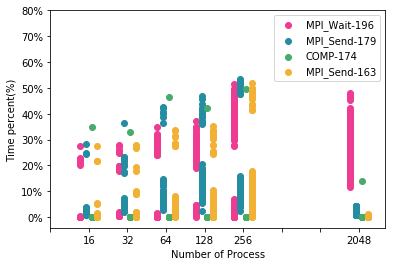

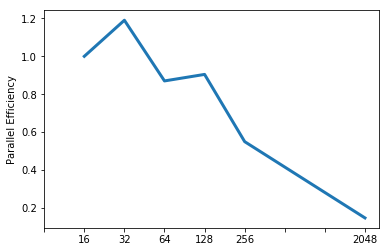

In [38]:
#sweep3d
from matplotlib.ticker import FuncFormatter
def findNodeWithUniqueId(node, uid):
    if node.uniqueId == uid: 
        return node, True;
    for child in node.children:
        #Node* findNode = nullptr
        findNode, findFlag = findNodeWithUniqueId(child, uid);
        if findFlag == True:
            return findNode, True;
    return node, False

def copyNodeData(node, data):
    for i in range(len(nprocs)):
        data[i] = node.sumTimeSecList[i]
    
    

findNode, findFlag = findNodeWithUniqueId(gatheredTree,196)
print(findNode.uniqueId,findNode.lineNum)
data1 = [None] * len(nprocs)
#print(findNode.sumTimeSecList[5])
#print(nprocs)
copyNodeData(findNode, data1)
print(data1[0])

findNode, findFlag = findNodeWithUniqueId(gatheredTree,179)
print(findNode.uniqueId,findNode.lineNum)
data2 = [None] * len(nprocs)
copyNodeData(findNode, data2)
print(data2[0])


findNode, findFlag = findNodeWithUniqueId(gatheredTree,169)
print(findNode.uniqueId,findNode.lineNum)
data3 = [None] * len(nprocs)
copyNodeData(findNode, data3)
print(data3[0])


findNode, findFlag = findNodeWithUniqueId(gatheredTree,163)
print(findNode.uniqueId,findNode.lineNum)
data4 = [None] * len(nprocs)
copyNodeData(findNode, data4)
print(data4[0])


all_data = [data1[0],data2[0],data3[0],data4[0],
            data1[1],data2[1],data3[1],data4[1],
            data1[2],data2[2],data3[2],data4[2],
            data1[3],data2[3],data3[3],data4[3],
            data1[4],data2[4],data3[4],data4[4],
            data1[5],data2[5],data3[5],data4[5]]

labels = [
            '  ',' 16',' ',' ',
          '  ', ' 32',' ',' ',
          '  ', ' 64',' ',' ',
          '  ' , ' 128',' ',' ',
          '  ' ,' 256',' ',' ',
          '  ',' 2048',' ',' ']
position = [0.775,0.925,1.075,1.225,
            1.775,1.925,2.075,2.225,
            2.775,2.925,3.075,3.225,
            3.775,3.925,4.075,4.225,
            4.775,4.925,5.075,5.225,
            7.775,7.925,8.075,8.225]

#bplot = plt.boxplot(all_data, patch_artist=True, widths=0.15, labels=labels,positions=position, showfliers=False,showmeans=False)  # 设置箱型图可填充
#plt.title('Bo')
#bplot = plt.boxplot(all_data, patch_artist=True, widths=0.15, labels=labels,positions=position)#, showfliers=False,showmeans=False)  # 设置箱型图可填充
colors = ['#ED3C92','#258DA1','#47AB6C','#F2B134']
splot = [None]*len(all_data)
for i in range(len(all_data)):
    x = [position[i]]*len(all_data[i])
    splot[i] = plt.scatter(x,all_data[i] , color = colors[i%4])
#plt.title('Bo')

colors = ['pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow', 
         'pink', 'lightblue', 'lightgreen', 'yellow']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)  # 为不同的箱型图填充不同的颜色

#plt.yaxis.grid(True)
#plt.yscale('log', basey=10)
plt.legend([splot[0],splot[1],splot[2],splot[3]],['MPI_Wait-196','MPI_Send-179','COMP-174','MPI_Send-163'],loc= 'upper right')#,bbox_to_anchor=(0.42, 1.02)) 
#fmt = '%1.0f%%' # Format you want the ticks, e.g. '40%'
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'

#plt.plot(meanposit1,mean1,color = '#ED3C92')
#plt.plot(meanposit2,mean2,color = '#258DA1')


#plt.plot(meanposit3,mean3,color = '#47AB6C')

#plt.plot(meanposit4,mean4,color = '#F2B134')

#yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.ylim(ymax = 0.8)
plt.xticks(numpy.arange(9),[' ','16','32','64','128','256',' ',' ','2048'])

plt.ylabel('Time percent(%)')
plt.xlabel('Number of Process')
plt.savefig('cg-distri.pdf',bbox_inches='tight')
plt.show()

plt.ylabel("Parallel Efficiency")
#plt.yscale('log',basey=10)
#pplot, = plt.plot([1,2,3,4,5,8],totalTime,color = '#ED5C31',linewidth=3,label='Total Time')

#totalTime2 =[20.7167,12.1307,9.3176,7.0226,6.0476,5.4934] #cholesky 6000 TH2 1
#pplot2, = ax2.plot([1,2,3,4,5,8],totalTime2,color = '#47AB6C',linewidth=3,label='Opt Total Time ')
totalTime = [31.98,13.43,9.19,4.42,3.64,1.71]
expectTotalTime = [totalTime[0]/totalTime[0],  (totalTime[0]/pow(2,1))/totalTime[1],  (totalTime[0]/pow(2,2))/totalTime[2],  (totalTime[0]/pow(2,3))/totalTime[3],(totalTime[0]/pow(2,4))/totalTime[4],(totalTime[0]/pow(2,7))/totalTime[5]]
pplot3,=plt.plot([1,2,3,4,5,8],expectTotalTime,linewidth = 3)
plt.xticks(numpy.arange(9),[' ','16','32','64','128','256',' ',' ','2048'])
#plt.yscale('log',basey=10)
plt.show()

In [8]:

def devideTotalTime(node):
    if node.hasMulTotalTime == 1:
        for i in range(len(node.sumTimeSecList)):
            for j in range(len(node.sumTimeSecList[i])):
                node.sumTimeSecList[i][j] = node.sumTimeSecList[i][j] / totalTime[i]
        node.hasMulTotalTime = 0
    for i in range(len(node.children)):
        devideTotalTime( node.children[i])

#mulTotalTime(gatheredTree)
devideTotalTime(gatheredTree)